In [1]:
import sys
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from dataloaders.params import INPUT_NAMES
import open3d as o3d
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from PIL import Image
import seaborn as sns
import pickle
from IPython import display
from util.visualization import visualize_sample
from util.eval import Result
import torch
import os
import numpy as np
import torch
import torch.nn as nn
from dataloaders.params import INPUT_NAMES
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from dataloaders.ntu_uwbloader import UwbDataLoader,obtain_scale
from dataloaders.ntu_uwbloader import NTULoader
from util.trainer import train,validate,network_train
from dataloaders.load_data import load_data
from models import mambaNet, rnn_attention
import torch
from models.load_model import load_model
### pip install mambapy to use the mamba block

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Define the parameters

In [2]:
is_train         = True         # training or testing
save_weights     = True         # whether save weights
training_dataset = 'NTU'        # selected from NTU and RONET
dataset_path     = './data'     # the path for the data dir
training_model   = 'MAMBA'      # selected from [MAMBA,BiLSTM,LSTM,GRU,RNN,BiRNN]
train_one_tag    = False        # only valid train on NTU dataset
train_on_slam    = False        # only valid train on NTU dataset
min_anc          = 1            # filter data at least min_anc number of anchors data is available
batchsize        = 64
seqlen           = 20           # the time length of the input uwb data L
coding_dim       = 128          # the dim of uwb embedding
hiddendim        = 256          # hidden size dimention of RNN based model
num_layers       = 4            # the num of layers for MAMBA
lr               = 0.001
weigt_decay      = 0.9
decay_rate       = 0.5
decay_step       = 20
num_epoch        = 100
device           = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if training_dataset=="NTU":
    if train_one_tag:
        input_dim    = 10
        output_dim   = 3
    else:
        input_dim    = 20
        output_dim   = 6
else:
    input_dim    = 8
    output_dim   = 2
    train_one_tag = True


save_dir         = f"output/{training_dataset}/checkpoints/{training_model}"
log_dir          =  f"output/{training_dataset}/logs/{training_model}"
os.makedirs(save_dir,exist_ok=True)
os.makedirs(log_dir,exist_ok=True)
save_path             = os.path.join(save_dir,"best_model")
saved_checkpoint_path = save_path  

### Create the dataloader

In [3]:
print(f"Train on {training_dataset} dataset")

if training_dataset=="NTU":
    train_dataset ,val_dataset,train_dataloader,val_dataloader,Xscaler, Yscaler = load_data(seqlen,batchsize,min_anc,training_dataset,train_on_slam,train_one_tag,dataset_path)
    test_dataloader = val_dataloader
else:
    train_dataloader,val_dataloader,test_dataloader, Yscaler = load_data(seqlen,batchsize,min_anc,training_dataset,train_on_slam,train_one_tag,dataset_path)

Train on NTU dataset
['./data/MCDUWB_nodelay/train/ntu_day_01_packed.csv', './data/MCDUWB_nodelay/train/ntu_day_03_packed.csv', './data/MCDUWB_nodelay/train/ntu_day_04_packed.csv', './data/MCDUWB_nodelay/train/ntu_day_05_packed.csv', './data/MCDUWB_nodelay/train/ntu_day_06_packed.csv', './data/MCDUWB_nodelay/train/ntu_day_07_packed.csv', './data/MCDUWB_nodelay/train/ntu_day_08_packed.csv', './data/MCDUWB_nodelay/train/ntu_day_09_packed.csv', './data/MCDUWB_nodelay/train/ntu_night_01_packed.csv', './data/MCDUWB_nodelay/train/ntu_night_03_packed.csv', './data/MCDUWB_nodelay/train/ntu_night_05_packed.csv', './data/MCDUWB_nodelay/train/ntu_night_06_packed.csv', './data/MCDUWB_nodelay/train/ntu_night_07_packed.csv', './data/MCDUWB_nodelay/train/ntu_night_08_packed.csv', './data/MCDUWB_nodelay/train/ntu_night_09_packed.csv', './data/MCDUWB_nodelay/train/ntu_night_10_packed.csv', './data/MCDUWB_nodelay/train/ntu_night_11_packed.csv', './data/MCDUWB_nodelay/train/ntu_night_12_packed.csv']
Load

### Create the model

In [4]:
model = load_model(training_model,input_dim,output_dim,coding_dim,num_layers, hiddendim, device)
model = model.to(device)

Num. of parameters:  482694


### Model training

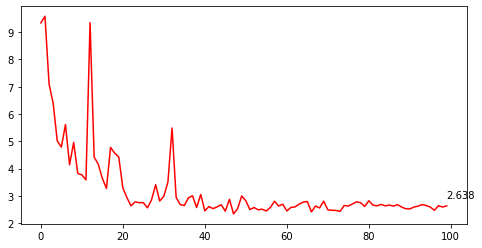

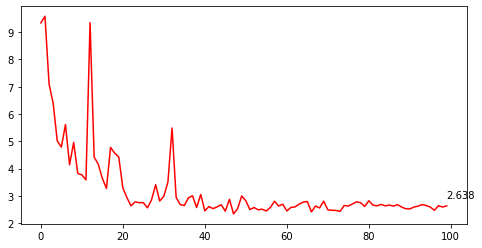

In [5]:
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr)
if is_train:
    print(f"Train on {training_dataset} dataset, the using model is {training_model}")
    vis = 1 # 1: plot the loss curve, 0: print the loss value
    res = network_train(model,training_dataset,train_dataloader, val_dataloader, Yscaler, criterion,optimizer,num_epoch,device,lr,decay_rate,decay_step,vis=vis,save_weights=save_weights,save_path=save_path,log_path=log_dir,half=train_one_tag,real=train_on_slam,)
else:
    print(f"Test on {training_dataset} dataset, the using model is {training_model}")
    model = torch.load(saved_checkpoint_path).to(device)
    res = validate(test_dataloader, model, training_dataset, 1, 'Test',device,Yscaler,half=train_one_tag)
    print((res))

### Model testing

In [10]:
print(f"Test on {training_dataset} dataset, the using model is {training_model}, load weights from: {saved_checkpoint_path}")
model = torch.load(saved_checkpoint_path).to(device)
model.eval()
res = validate(test_dataloader, model, training_dataset,1, 'Test',device,Yscaler,half=train_one_tag)
print(res)

Test on NTU dataset, the using model is MAMBA, load weights from: output/NTU/checkpoints/MAMBA/best_model


Epoch:  1. 540 / 541 | Mode: Test. RMSE: 2.341475. MEAN:  0.603771. MEDIAN: 0.193382


### Visualize the test results on NTU dataset

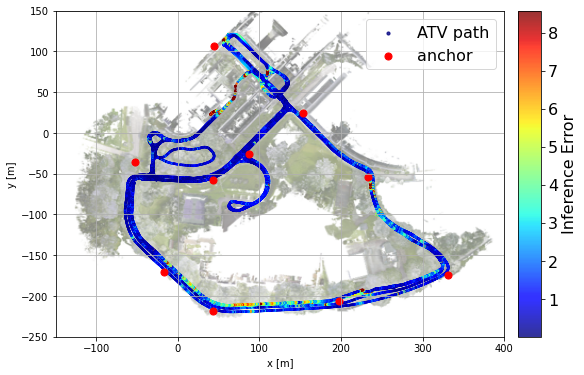

In [7]:
from util.visualization import plotPathError
# Plot the error based on location
test_dataset = val_dataset
# Initialize variables for chunk processing
chunk_size = 1000
total_data = test_dataset.getX().shape[0]
num_chunks = total_data // chunk_size
testErrScaler = MinMaxScaler(feature_range=(0, 1))

# Initialize lists to accumulate results
all_Y = []
all_Ypred = []
all_errors = []

# Iterate over each chunk
for i in range(num_chunks):
    # Load a chunk of data
    X = test_dataset.getX()[i*chunk_size:(i+1)*chunk_size, :, :]
    Y = test_dataset.getY()[i*chunk_size:(i+1)*chunk_size, :, :]
    Y = torch.cat((Y[0, :, :], Y[:, -1, :]), dim=0)
    Y = Yscaler.inverse_transform(Y.cpu())

    Ypred = model(X.float().to(device)).cpu().detach()
    Ypred = torch.cat((Ypred[0, :, :], Ypred[:, -1, :]), dim=0)
    Ypred = Yscaler.inverse_transform(Ypred.cpu())

    test_res = Result(half=train_one_tag)
    test_res.evaluate(Ypred, Y)
    test_err = np.linalg.norm(test_res.abs_diff, axis=1)

    # Accumulate results
    all_Y.append(Y)
    all_Ypred.append(Ypred)
    all_errors.append(test_err)

    # Clear memory for this chunk
    del X, Y, Ypred, test_res, test_err
    torch.cuda.empty_cache()

# Combine accumulated results into a single array
all_Y = np.vstack(all_Y)
all_Ypred = np.vstack(all_Ypred)
all_errors = np.concatenate(all_errors)

# Calculate global statistics for error clamping
mean = np.mean(all_errors)
colorScalePiv = mean + 2 * np.var(all_errors)

# Clamp the error color globally
all_errors[all_errors > colorScalePiv] = colorScalePiv

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
all_Y, all_Ypred = plotPathError(all_Y, all_Ypred, ax,colorScalePiv,train_on_slam,train_one_tag)

### Plot the error for each sequence

Path is not dir
['./data/MCDUWB_nodelay/test/ntu_night_02_packed.csv']
Loading file ./data/MCDUWB_nodelay/test/ntu_night_02_packed.csv. Size: 67
Number of samples: 13235


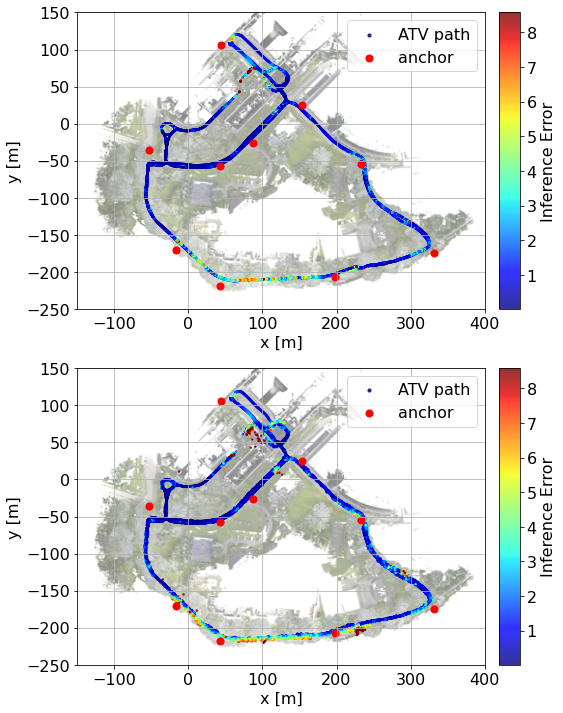

Path is not dir
['./data/MCDUWB_nodelay/test/ntu_night_13_packed.csv']
Loading file ./data/MCDUWB_nodelay/test/ntu_night_13_packed.csv. Size: 67
Number of samples: 4640


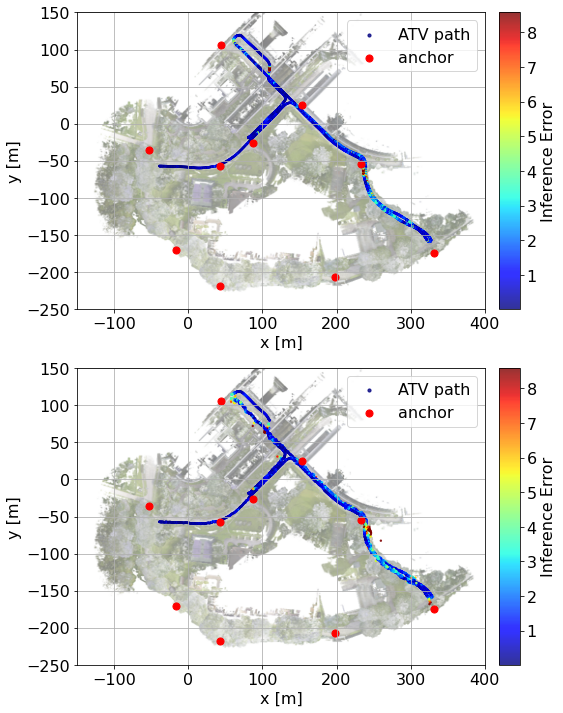

Path is not dir
['./data/MCDUWB_nodelay/test/ntu_night_04_packed.csv']
Loading file ./data/MCDUWB_nodelay/test/ntu_night_04_packed.csv. Size: 67
Number of samples: 5787


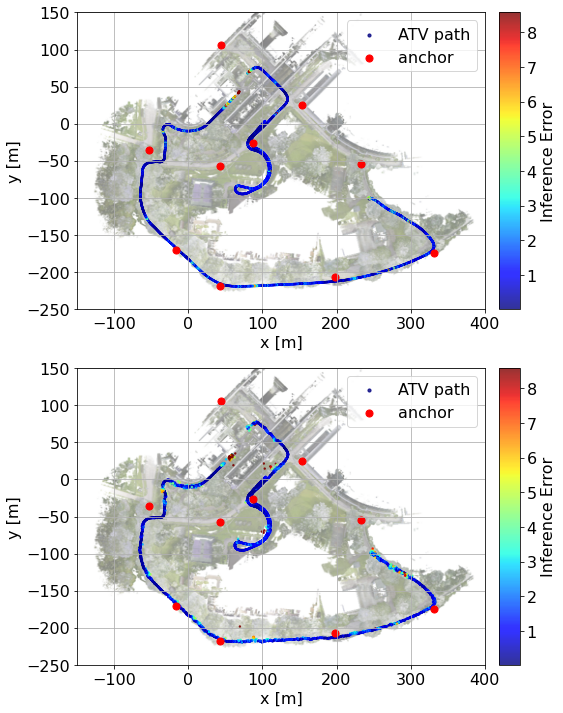

Path is not dir
['./data/MCDUWB_nodelay/test/ntu_day_10_packed.csv']
Loading file ./data/MCDUWB_nodelay/test/ntu_day_10_packed.csv. Size: 67
Number of samples: 6365


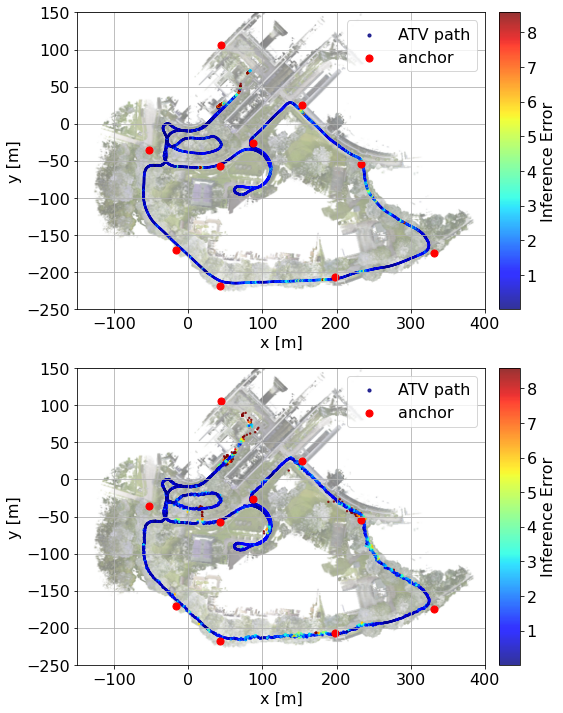

Path is not dir
['./data/MCDUWB_nodelay/test/ntu_day_02_packed.csv']
Loading file ./data/MCDUWB_nodelay/test/ntu_day_02_packed.csv. Size: 67
Number of samples: 4535


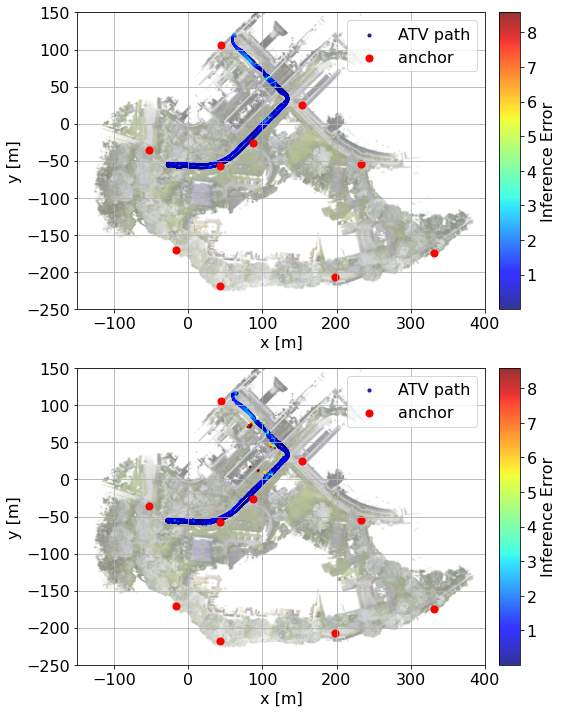

In [8]:
if train_on_slam:
    test_path = os.path.join(dataset_path,"MCDUWB_slamprior/test")
else:
    test_path = os.path.join(dataset_path,"MCDUWB_nodelay/test")

chunk_size = 1000  # Size of each chunk
test_seq = glob.glob(test_path + '/*.csv')
figsize = (8, 12)
test_df = None

for seqidx, seq in enumerate(test_seq):
    
    seq_name = os.path.basename(seq).replace('_packed.csv', '')
    # Load dataset and dataloader
    seq_dataset = NTULoader(seq, seqlen=seqlen, Xscaler=Xscaler, Yscaler=Yscaler,min_anc=min_anc,half=train_one_tag)
    X = seq_dataset.getX()
    Y = seq_dataset.getY()
    total_data = X.shape[0]
    num_chunks = total_data // chunk_size

    all_Y = []
    all_Ypred = []
    all_errors = []

    # Process each chunk
    for i in range(num_chunks):
        # print(f"Processing chunk {i + 1}/{num_chunks} of sequence {seqidx + 1}/{len(test_seq)}...")

        # Load a chunk of data
        X_chunk = X[i*chunk_size:(i+1)*chunk_size, :, :]
        Y_chunk = Y[i*chunk_size:(i+1)*chunk_size, :, :]
        Y_chunk = torch.cat((Y_chunk[0, :, :], Y_chunk[:, -1, :]), dim=0)
        Y_chunk = Yscaler.inverse_transform(Y_chunk.cpu())

        # Predict
        Ypred_chunk = model(X_chunk.float().to(device)).cpu().detach()
        Ypred_chunk = torch.cat((Ypred_chunk[0, :, :], Ypred_chunk[:, -1, :]), dim=0)
        Ypred_chunk = Yscaler.inverse_transform(Ypred_chunk.cpu())

        # Evaluate errors
        chunk_res = Result(half=train_one_tag)
        chunk_res.evaluate(Ypred_chunk, Y_chunk)
        chunk_err = np.linalg.norm(chunk_res.abs_diff, axis=1)

        # Accumulate results
        all_Y.append(Y_chunk)
        all_Ypred.append(Ypred_chunk)
        all_errors.append(chunk_err)

        # Clear memory for this chunk
        del X_chunk, Y_chunk, Ypred_chunk, chunk_res, chunk_err
        torch.cuda.empty_cache()

    # Combine results of all chunks
    all_Y = np.vstack(all_Y)
    all_Ypred = np.vstack(all_Ypred)
    all_errors = np.concatenate(all_errors)
    
    # Plot the results for the current sequence
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=figsize)

    all_Y1, all_Ypred1 = plotPathError(all_Y, all_Ypred, ax[0],colorScalePiv,train_on_slam,train_one_tag)

    # Calculate RMSE for the entire sequence
    seq_res = Result(half=train_one_tag)
    seq_res.evaluate(all_Ypred, all_Y)


    # Real metric Error
    err = np.linalg.norm(seq_res.abs_diff, axis=1)


    df = pd.DataFrame(err, columns=['error'])
    df['seq'] = seq_name

    # Concatenate the DataFrame for later representation
    test_df = df if test_df is None else pd.concat([test_df, df])

    all_Ypred2, all_Y2 = plotPathError(all_Ypred, all_Y, ax[1],colorScalePiv,train_on_slam,train_one_tag)

    plt.show()


### Plot the violin plot

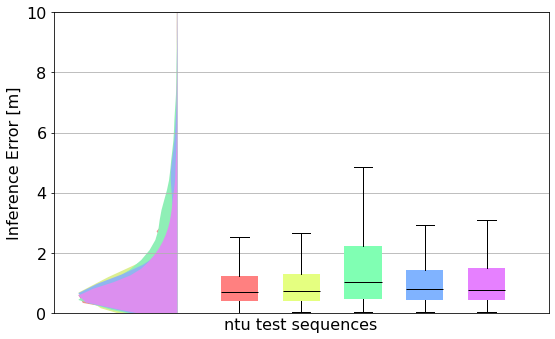

In [9]:
import colorsys

# Map sequence to camp (here it's 'ntu')
test_df['camp'] = test_df['seq'].apply(lambda x: 'ntu')

# Get the list of sequences and sort them
sequences = sorted(list(set(test_df['seq'])))
Nseq = len(sequences)

# Generate colors for each sequence
colors = []
for i in range(Nseq):
    rgb = colorsys.hsv_to_rgb(i / Nseq, 0.5, 1.0)
    colors.append(rgb)

figsize = (8, 5)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
dx = 'seq'
dy = 'error'
sigma = 0.6
ort = "v"
cut = 0.0

# Plot the violin plots
for idx, seq in enumerate(sequences):
    df = test_df[test_df['seq'] == seq].copy()
    df['xtick'] = df['seq'].apply(lambda x: -1)  # xtick position for violin plot

    # Draw violin plot
    violin = sns.violinplot(
        ax=ax, x='xtick', y=dy, data=df, scale="width", inner=None, color=colors[idx]
    )

    # Modify to only draw half of the violin
    v = violin.collections[-1]
    m = np.mean(v.get_paths()[0].vertices[:, 0])
    v.get_paths()[0].vertices[:, 0] = np.clip(v.get_paths()[0].vertices[:, 0], -np.inf, m)
    v.set_edgecolor('none')

    plt.xticks([-1], [''])

# Plot the box plots
for idx, seq in enumerate(sequences):
    df = test_df[test_df['seq'] == seq].copy()
    df['xtick'] = idx  # xtick position for box plot

    ax.boxplot(
        df['error'],
        positions=[0.25 + idx * 0.25],
        patch_artist=True,
        medianprops=dict(color='black'),
        boxprops=dict(facecolor=colors[idx], edgecolor='none'),
        showfliers=False
    )
    plt.xticks([-1], [''])

# Add legend
handles = [plt.Line2D([], [], color=color, marker='s', linestyle='None') for color in colors]
labels = [seq.replace('ntu_', '') for seq in sequences]  # Labels for each sequence

# ax.legend(handles, labels)

# Format the plot
ax.set_xlim([-0.5, 1.5])
ax.set_ylim([0, 10])

ax.set_xlabel('ntu test sequences')
ax.set_ylabel('Inference Error [m]')

ax.grid(True)
plt.tight_layout()
plt.show()